In [12]:
%matplotlib inline
from truckscenes import TruckScenes
import os

path = '/data/mint/Radar_Dataset/ManTruck/man-truckscenes/'
trucksc = TruckScenes('v1.0-mini', path, True)

Loading truckscenes tables for version v1.0-mini...
11 attribute,
18 calibrated_sensor,
27 category,
20090 ego_motion_cabin,
20089 ego_motion_chassis,
20116 ego_pose,
1094 instance,
400 sample,
25750 sample_annotation,
43556 sample_data,
10 scene,
18 sensor,
4 visibility,
Done loading in 1.663 seconds.
Reverse indexing ...
Done reverse indexing in 0.4 seconds.


None


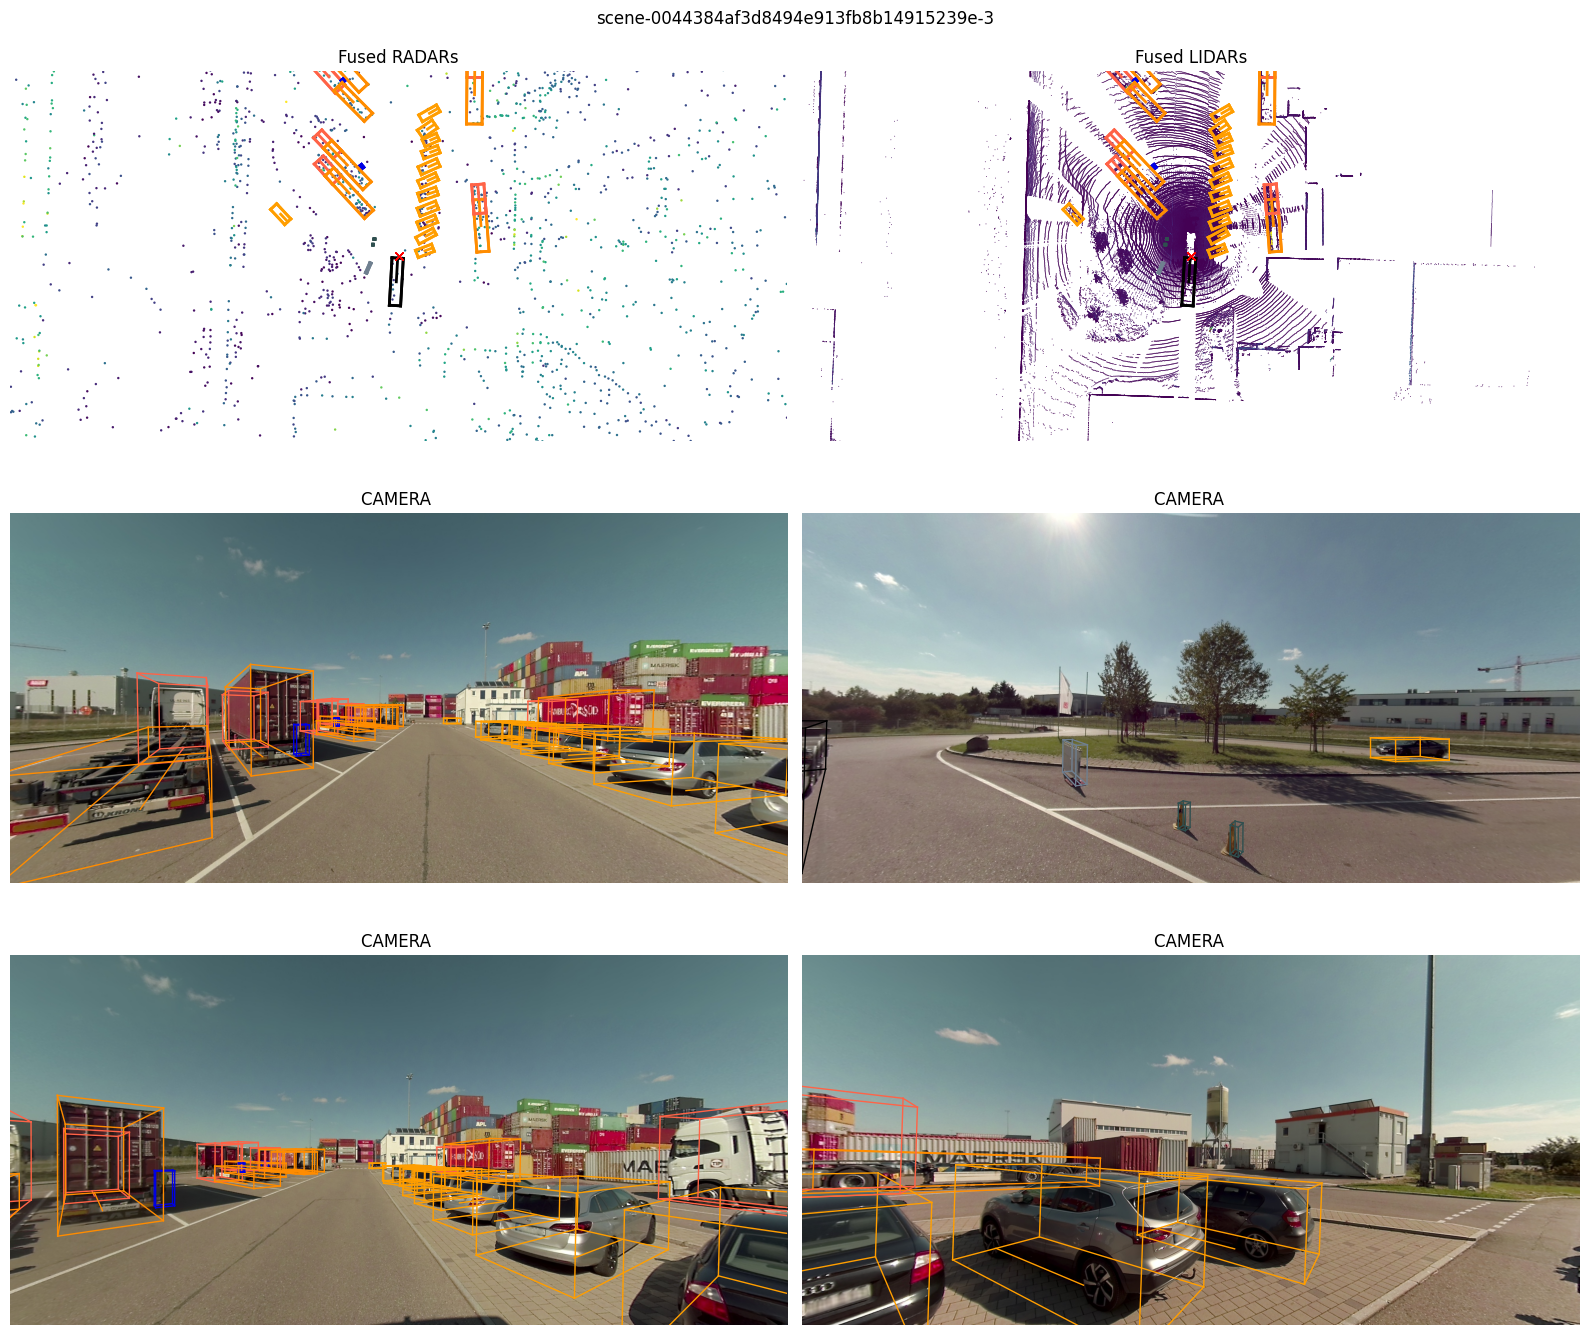

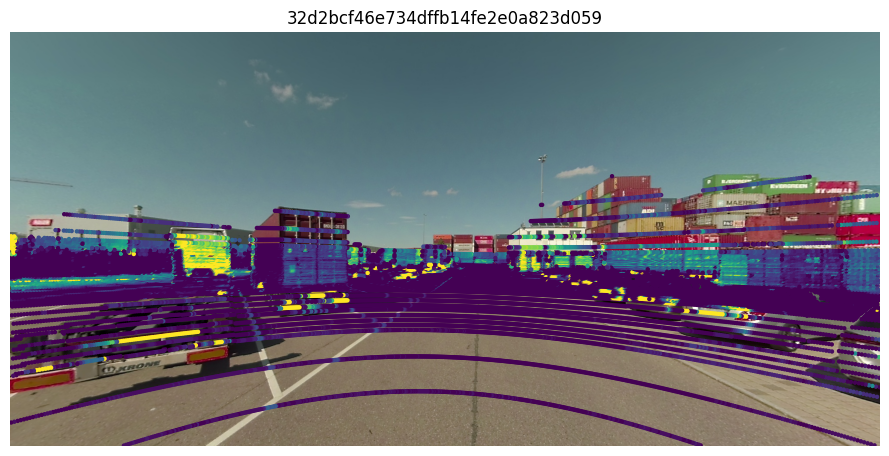

In [30]:
my_scene = trucksc.scene[0]
first_sample_token = my_scene['first_sample_token']
trucksc.render_sample(first_sample_token)
my_sample = trucksc.get('sample', first_sample_token)
radar_pts = trucksc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_LEFT', camera_channel='CAMERA_LEFT_FRONT', render_intensity=True, dot_size=10)
# radar_pts = trucksc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_LEFT', camera_channel='CAMERA_LEFT_FRONT', render_intensity=True, dot_size=10)
print(radar_pts)

# Get data pts

In [44]:
from truckscenes.utils.data_classes import LidarPointCloud, RadarPointCloud
import matplotlib.pyplot as plt
from pyquaternion import Quaternion
from PIL import Image
import numpy as np

sample_record = trucksc.get('sample', first_sample_token)
print(sample_record)

# Here we just grab the front camera and the point sensor.
pointsensor_token = sample_record['data']['RADAR_LEFT_FRONT']
camera_token = sample_record['data']['CAMERA_LEFT_FRONT']
cam = trucksc.get('sample_data', camera_token)
pointsensor = trucksc.get('sample_data', pointsensor_token)
pcl_path = os.path.join(trucksc.dataroot, pointsensor['filename'])
pc = RadarPointCloud.from_file(pcl_path)
# pc = LidarPointCloud.from_file(pcl_path)

# Transformation
# First step: transform from the point sensor into the ego vehicle frame.
cs_record = trucksc.get('calibrated_sensor', pointsensor['calibrated_sensor_token'])
pc_sensor = pc.points.copy()
pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
pc.translate(np.array(cs_record['translation']))
pc_ego = pc.points.copy()
print(np.mean(pc.points, axis=1))

# Second step: transform from ego to the global frame.
poserecord = trucksc.get('ego_pose', pointsensor['ego_pose_token'])
pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
pc.translate(np.array(poserecord['translation']))
pc_global = pc.points.copy()
print(np.mean(pc.points, axis=1))

# Third step: transform from global into the ego vehicle frame
# for the timestamp of the image.
poserecord = trucksc.get('ego_pose', cam['ego_pose_token'])
pc.translate(-np.array(poserecord['translation']))
pc.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)
pc_ego2 = pc.points.copy()
print(np.mean(pc.points, axis=1))

# Fourth step: transform from ego into the camera.
cs_record = trucksc.get('calibrated_sensor', cam['calibrated_sensor_token'])
pc.translate(-np.array(cs_record['translation']))
pc.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)
pc_cam = pc.points.copy()
print(np.mean(pc.points, axis=1))

pc_dat = [pc_sensor, pc_ego, pc_global, pc_ego2, pc_cam]
pc_name = ['pc_sensor', 'pc_ego', 'pc_global', 'pc_ego2', 'pc_cam']
# For loop to check diff between each step
for i in range(len(pc_dat)):
    for j in range(len(pc_dat)):
        if i != j:
            diff = pc_dat[i] - pc_dat[j]
            print(f"Difference between {pc_name[i]} and {pc_name[j]}: {np.mean(diff)}, {np.allclose(pc_dat[i], pc_dat[j])}")

im = Image.open(os.path.join(trucksc.dataroot, cam['filename']))
print(pc.points.shape)

{'token': '32d2bcf46e734dffb14fe2e0a823d059', 'scene_token': '044c648ac12345f1aedf33c9f91cdc5a', 'timestamp': 1695473372698161, 'prev': '', 'next': 'deb7b3f332f042d49e7636d6e4959354', 'data': {'RADAR_RIGHT_BACK': 'c790efd2151d491aae635234a5df26d8', 'RADAR_RIGHT_SIDE': '7f3083ba7f2e49678b4ccbc2fd14f590', 'RADAR_RIGHT_FRONT': '36c9a2c6b3ee4d9f9d01c902521cbb27', 'RADAR_LEFT_FRONT': '1e6375db490e4563b55fce389b06a53b', 'RADAR_LEFT_SIDE': 'c58e24c2e644404f85a5c0901d367338', 'RADAR_LEFT_BACK': 'e940e3abeab34da8833e013c84b52366', 'LIDAR_LEFT': '9ae8f9fd6cd2458298c82eb6a85119a6', 'LIDAR_RIGHT': '28a12ab75263458a977dd29ca4e54ee2', 'LIDAR_TOP_FRONT': '1ac1e8bcd1ed4493a73c011dc2441713', 'LIDAR_TOP_LEFT': '85c18e7eeb3c42f194eba257dcf6d66c', 'LIDAR_TOP_RIGHT': '064d8efa5f31493db10f96dbeef91282', 'LIDAR_REAR': '18b4fe677dc7408b84ebd555c559da16', 'CAMERA_LEFT_FRONT': '7625b794c8a14e918dc23113ee5d10da', 'CAMERA_LEFT_BACK': 'c6e32737071942fb9d5bcd8c69a88181', 'CAMERA_RIGHT_FRONT': '4e11f21f05be46f3b219a